In [31]:
# Run some setup code for this notebook.
import matplotlib.pyplot as plt
import numpy as np


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 10) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
df = pd.read_csv('./data/mnist.csv') 
data = df.values
X = data[:, 1:]
y = data[:, 0]

print(f"{X.shape = }, {y.shape = }")

min_val = X.min()
max_val = X.max()

# X = (X - min_val) / (max_val - min_val)



X.shape = (1000, 784), y.shape = (1000,)


## PCA

In [33]:
# 实现pca算法并与对比sklearn
def pca(X, variance_threshold):
    X_mean = np.mean(X, axis=0)
    X_centered = np.subtract(X, X_mean)

    cov = np.cov(X_centered.T)

    # 特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    idx = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, idx]
    sorted_eigenvalues = eigenvalues[idx]

    # calculate d'
    total_variance = sum(sorted_eigenvalues)
    variance_sum = 0
    n_components = 0
    for value in sorted_eigenvalues:
        variance_sum += value
        n_components += 1
        if variance_sum / total_variance >= variance_threshold:
            break

    components = sorted_eigenvectors[:, :n_components]

    # 降维
    X_transformed = np.dot(X_centered, components)

    # 重构
    X_reconstructed = np.dot(X_transformed, components.T) + X_mean

    # 计算重构误差
    return X_reconstructed


from sklearn.decomposition import PCA

def sklearn_pca(X, variance_threshold):
    pca = PCA(n_components=variance_threshold)
    X_transformed = pca.fit_transform(X)

    X_reconstructed = pca.inverse_transform(X_transformed)
    return X_reconstructed




#### 对比

In [34]:
variance_threshold = 0.95

X_reconstructed = pca(X, variance_threshold)
X_reconstructed_sklearn = sklearn_pca(X, variance_threshold)
reconstructed_error = np.mean(np.square(X - X_reconstructed))
print(f"manual_reconstructed_error  = {reconstructed_error}")
reconstructed_error = np.mean(np.square(X - X_reconstructed_sklearn))
print(f"sklearn_reconstructed_error = {reconstructed_error}")

manual_reconstructed_error  = 222.27690578580916
sklearn_reconstructed_error = 222.27690578580916


In [35]:
variance_threshold = 0.9

X_reconstructed = pca(X, variance_threshold)
X_reconstructed_sklearn = sklearn_pca(X, variance_threshold)
reconstructed_error = np.mean(np.square(X - X_reconstructed))
print(f"manual_reconstructed_error  = {reconstructed_error}")
reconstructed_error = np.mean(np.square(X - X_reconstructed_sklearn))
print(f"sklearn_reconstructed_error = {reconstructed_error}")

manual_reconstructed_error  = 446.80245727695075
sklearn_reconstructed_error = 446.802457276951


In [36]:
variance_threshold = 0.98

X_reconstructed = pca(X, variance_threshold)
X_reconstructed_sklearn = sklearn_pca(X, variance_threshold)
reconstructed_error = np.mean(np.square(X - X_reconstructed))
print(f"manual_reconstructed_error  = {reconstructed_error}")
reconstructed_error = np.mean(np.square(X - X_reconstructed_sklearn))
print(f"sklearn_reconstructed_error = {reconstructed_error}")

manual_reconstructed_error  = 88.8077386205223
sklearn_reconstructed_error = 88.80773862052229


## MDS

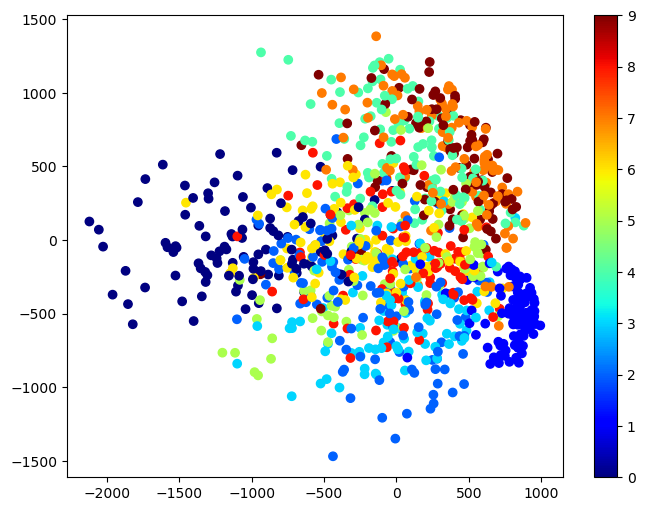

In [37]:
# 实现流形学习算法
# X_mean = np.mean(X, axis=0)
# X = np.subtract(X, X_mean)

# distance matrix
def mds(X, dimension):
    X_mean = np.mean(X, axis=0)
    X = np.subtract(X, X_mean)

    m, n = X.shape
    X_square = np.square(X)
    ones = np.ones((m, n))
    D_square = X_square @ ones.T + ones @ X_square.T - 2 * X @ X.T
    distance = np.sqrt(np.abs(D_square))
    distance_square = np.abs(D_square)

    # Calculate matrix B
    centering_matrix = np.eye(m) - np.ones((m, m)) / m
    B = -0.5 * centering_matrix @ distance_square @ centering_matrix

    # 特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eigh(B)

    # Sorting
    idx = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, idx]
    sorted_eigenvalues = eigenvalues[idx]

    # select dimension
    eigenvectors_selected = sorted_eigenvectors[:, :dimension]
    eigenvalues_selected = sorted_eigenvalues[:dimension]

    X_reduced = eigenvectors_selected @ np.diag(np.sqrt(eigenvalues_selected))
    return X_reduced

X_reduced = mds(X, 2)
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.colorbar()
plt.show()



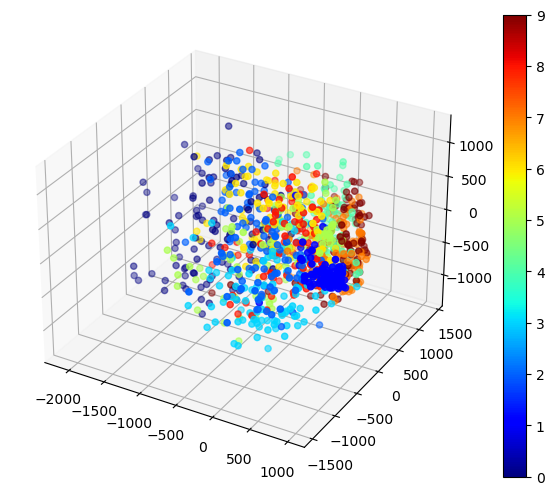

In [38]:
X_reduced = mds(X, 3)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap="jet")
plt.colorbar(scatter, ax=ax)
plt.show()

## SKLearn MDS

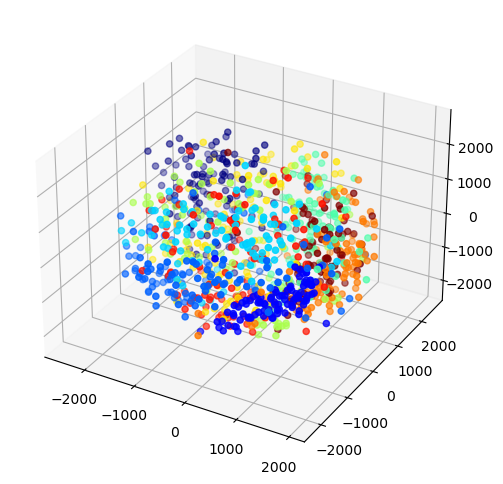

In [39]:
from sklearn.manifold import MDS
mds = MDS(n_components=3, random_state= 0)

X_mds = mds.fit_transform(X)
# plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
# plt.colorbar()


# 创建 3D 绘图
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_mds[:, 0], X_mds[:, 1], X_mds[:, 2], c=y, cmap="jet")


plt.show()

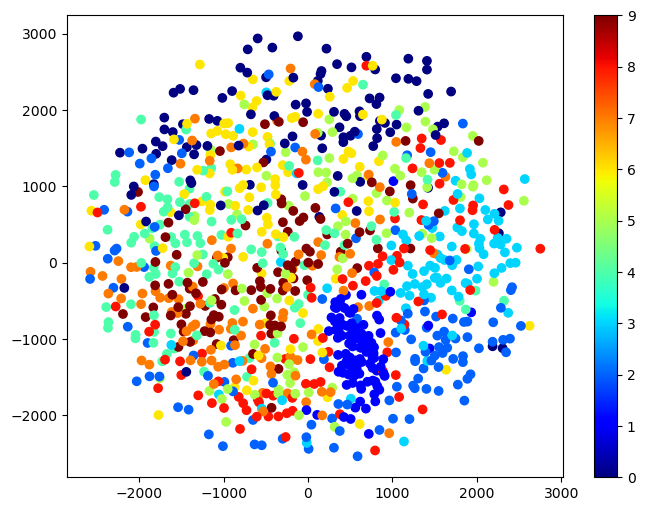

In [40]:

mds = MDS(n_components=2, random_state= 0)

X_mds = mds.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y, cmap="jet")
plt.colorbar()
plt.show()